# SPoOkY Meshes 👻

In [11]:
import time

import numpy as np
import scipy as sp
import meshplot as mp

import matplotlib.pyplot as plt

import scipy.sparse
import scipy.sparse.linalg
import meshio
import IPython

In [12]:
def load_mesh(filename):
    m = meshio.read(filename)
    v = m.points
    f = m.cells[0].data
    # center and scale mesh
    v = v - np.mean(v, axis=0)
    v = v / np.max(np.std(v, axis=0))
    return v, f


def save_mesh(filename, v, f):
    m  = meshio.Mesh(v, f)
    m.write(filename)


v1, f1 = load_mesh('example_meshes/curvatures/plane.obj')
v2, f2 = load_mesh('example_meshes/curvatures/lilium_s.obj')
v3, f3 = load_mesh('example_meshes/decompose/armadillo.obj')
v4, f4 = load_mesh('example_meshes/smoothing/fandisk_ns.obj')
v5, f5 = load_mesh('example_meshes/smoothing/plane_ns.obj')
v7, f7 = load_mesh('sappho-hires.obj')
v8, f8 = load_mesh('gargoyle.off')

In [13]:
def standardize(v):
    """
    recenter points
    """
    v = v - np.mean(v, axis=0)
    v = v / np.std(v, axis=0).max()
    return v


def percentile_clip(h, n):
    """
    reject outlier points
    """
    return np.clip(h, np.percentile(h, n), np.percentile(h, 100 - n))

In [14]:
# Unsexy test mesh for debugging
v0 = np.array([
    [ 0, 0, 0],
    [-3, 4, 0],
    [-6, 0, 0],
    [-3,-4, 0],
    [ 3,-4, 0],
    [ 6, 0, 0],
    [ 3, 4, 0],
], dtype=np.float32)

f0 = np.array([
    [0, 1, 2],
    [0, 2, 3],
    [0, 3, 4],
    [0, 4, 5],
    [0, 5, 6],
    [0, 1, 6],
], dtype=np.int32)

# perturbed vertex indices to throw off naive algorithms
# f0 = np.array([
#     [1, 0, 2],
#     [2, 3, 0],
#     [0, 3, 4],
#     [4, 0, 5],
#     [5, 6, 0],
#     [6, 1, 0],
# ], dtype=np.int32)

## Laplace-Beltrami and Friends

### Vertex Area

In [15]:
def normalize(v):
    """
    normalize rows of vectors
    """
    return v / np.linalg.norm(v, axis=1)[:, np.newaxis]


def edges(f, n):
    """
    build an adjacency matrix, return edges in only one direction (upper triangular)
    """
    A = sp.sparse.triu(adjacency(f, n))
    ei, ej = A.nonzero()
    ed = np.vstack([ei, ej]).T
    # sort for consistency
    return np.sort(ed, axis=0)


def adjacency(f, n):
    """
    build a sparse adjacency matrix from faces in coordinate format.
    faces have some redundancy which we use a bitmask to filter.
    """
    A = sp.sparse.dok_matrix((n, n), dtype=bool)
    i, j, k = f.T
    A[i, j] = True
    A[j, k] = True
    A[k, i] = True
    A = A.tocsr()
    A = A + A.T
    return A


def face_normals(v, f):
    """
    compute normals of faces f
    """
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]
    
    # Compute edges, ensuring correct winding order
    ei = b - c
    ek = a - b

    # Compute the face normals
    n = np.cross(ek, ei, axis=1)

    return normalize(n)


def triangle_area(v, f):
    """
    compute triangle areas
    """
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]

    ac = c - a
    bc = c - b

    return np.linalg.norm(np.cross(ac, bc, axis=1), axis=1) / 2


def vertex_area(v, f):
    """
    compute total area about vertices
    3.59ms for 281,724 faces, not bad son
    """
    n = len(v)
    A = np.zeros((3, len(f)))

    area = triangle_area(v, f)

    # set internal angles at vertex location in face array
    # using indexes that have duplicate values to increment doesn't work
    A[0] = area
    A[1] = area
    A[2] = area

    # some esoteric numpy for summing at duplicated indices
    # coo matrices are also an option
    data = A.ravel()
    cols = f.T.ravel()

    M = np.zeros(n)
    np.add.at(M, cols, data)

    return sp.sparse.diags(M)


def barycentric_mass(v, f):
    return vertex_area(v, f) / 3


M = barycentric_mass(v0, f0)
assert list(M.diagonal()) == [24, 8, 8, 8, 8, 8, 8]

assert len(edges(f0, len(v0))) == 12

# Cotangent operator

In [16]:
def cotangent_curvature(v, f):
    """
    we can sum the contribution of all adjacent angles,
    then subtract the contribution of all interior angles.
    
    using edges would probably avoid some redundant work here (as above).

    133ms seconds for 281,724 faces. igl is 52.2ms.
    """
    n = len(v)
    
    # indices
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]

    # vectors
    ab = b - a
    ac = c - a
    bc = c - b
    
    # big chungus cotangent computation
    abc = np.einsum('ij,ij->i', ab, ac) / np.linalg.norm(np.cross( ab, ac, axis=1), axis=1)
    bac = np.einsum('ij,ij->i',-ab, bc) / np.linalg.norm(np.cross(-ab, bc, axis=1), axis=1)
    cab = np.einsum('ij,ij->i',-ac,-bc) / np.linalg.norm(np.cross(-ac,-bc, axis=1), axis=1)

    # set weights for opposite edges
    # a csr_matrix will sum the quantities for us!
    data = np.hstack([cab, abc, bac])
    rows = np.hstack([i,   j,   k, ])
    cols = np.hstack([j,   k,   i, ])
    T = sp.sparse.csr_matrix((data, (rows, cols)))

    # mad gains by flipping across the diagonal ;)
    T = T + T.T

    # Nearly there. sum the rows and use as diagonal.
    S = sp.sparse.diags(T.sum(axis=1).A.ravel())
    T = S - T

    # i'm never doing this again
    # divide by two as we have computed k_1 + k_2
    return T / 2


# %timeit cotangent_curvature(v7, f7)

C = cotangent_curvature(v0, f0)
T = np.diag(np.round((180 / np.pi) * C.todense()))

assert list(T) == [205, 73, 60, 73, 73, 60, 73]
assert np.sum(C) < 1e-6

### Test Mesh

In [17]:
mp.plot(v0, f0, shading={'wireframe': True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### Check that mean curvature works

In [18]:
v, f = v8, f8

def mean_curvature_metric(v, f):
    M = barycentric_mass(v, f)
    C = cotangent_curvature(v, f)
    Mi = sp.sparse.diags(1 / M.diagonal())
    Hn = -Mi @ C @ v
    H  = np.linalg.norm(Hn, axis=1)
    return H


c = percentile_clip(mean_curvature_metric(v, f), 5)

mp.plot(v, f, c)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.212662…

### Gradient and Divergence Operators

In [64]:
def grad(v, f):    
    # G_F is a diagonal matrix with the areas of the faces along the diagonal, repeated three times
    area = triangle_area(v, f)

    # Preprocess by computing 1/(2*G)
    G_F = scipy.sparse.diags(1 / np.tile(2 * area, 3))

    # To build E:
    # Get the edges opposite each vertex
    # Vectors should form a closed chain and sum to zero in a counterclockwise direction
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]

    ei = b - c
    ej = c - a
    ek = a - b

    # Compute the face normals
    n = normalize(np.cross(ek, ei, axis=1))
    
    # Rotate each edge by 90 degrees s.t. it points inward
    # Rotation is just the cross product with normal
    ei = np.cross(ei, n, axis=1)
    ej = np.cross(ej, n, axis=1)
    ek = np.cross(ek, n, axis=1)

    # Fill up the matrix E, which is 3|F| x V
    r = np.arange(len(f) * 3)
    rows = np.hstack([r, r, r])
    cols = np.hstack([i, i, i, j, j, j, k, k, k])
    data = np.hstack([
        ei[:, 0], ei[:, 1], ei[:, 2],
        ej[:, 0], ej[:, 1], ej[:, 2],
        ek[:, 0], ek[:, 1], ek[:, 2],
    ])

    E = scipy.sparse.coo_matrix((data, (rows, cols)))

    # Grad is G_F x E
    return G_F @ E

# Assert all rows of test mesh sum to 0
G = grad(v0, f0)
assert np.allclose(G.sum(1).ravel(), np.zeros(18))

In [65]:
def div(v, f):
    G = grad(v, f)
    A = barycentric_mass(v, f)
    area = triangle_area(v, f)
    TA = scipy.sparse.diags(np.tile(area, 3))
    D = -sp.sparse.diags(1 / A.diagonal()) @ G.T @ TA
    return D


# Assert sums for test mesh
D = div(v0, f0)
assert np.allclose(D.sum(1).ravel(), [0, -0.3125, 0.5, 0.8125, 0.3125, -0.5, -0.8125])

In [21]:
def edge_grad(v, f):
    """
    appendix B.3: Edge based gradient
    build an |E| x |F| adjacency matrix where each row sums to 0
    ~280ms for ~280000 faces, mostly due to sorting
    """
    i, j, k = f.T
    # edges
    ed = np.hstack([
        [i, j],
        [j, k],
        [k, i],
    ])
    # test for jump discontinuity
    ix = np.argwhere(ed[0] < ed[1])
    # remove discontinuities
    ed.sort(axis=0)
    # rows are indices into unique edges
    ed, rows = np.unique(ed, axis=1, return_inverse=True)
    # columns are triangle indices
    cols = np.tile(np.arange(len(f)), 3)
    # use indices to mask duplicate values, s.t. all rows sum to 1 for a closed manifold
    data = 0 - np.ones(len(rows))
    data[ix] = 1
    # return edge-triangle adjacency matrix
    G = scipy.sparse.coo_matrix((data, (rows, cols)))
    # while we're in town, build edge lengths
    el = np.linalg.norm(v[ed[1]] - v[ed[0]], axis=1)
    return G, ed.T, el

# assert interior edges sum to 0, exterior edges sum to 1
G, ed, el = edge_grad(v0, f0)
Ti = scipy.sparse.diags(1 / triangle_area(v0, f0))

# the test mesh is not a closed manifold, so these results are weird
# but they are correct!
assert len(ed) == 12
assert np.allclose(G.sum(axis=0).A.ravel(), [1, 1, 1, 1, 1, 1])
assert np.allclose(G.sum(axis=1).A.ravel(), [2, 0, 0, 0, 0, -2, 1, 1, 1, 1, 1, 1])
assert np.allclose(el, [5, 6, 5, 5, 6, 5,5, 6, 5, 6, 5, 5])

### Reconstruction

Reconstruct a mesh from a normal field

In [66]:
def vertex_from_normals(v, f, n):
    """
    compute vertices from normals
    """
    eps = 1e-10
    n = normalize(n)
    G = grad(v, f)
    D = div(v, f)
    A = barycentric_mass(v, f)
    D = A @ D
        
    # ???
    vv = G @ v

    L = cotangent_curvature(v, f)
    
    # w = np.zeros_like(vv)
    
    # if len(n) > len(f):
    #     w = vv - np.sum(vv * n, 1)[:, np.newaxis] * n
    # else:
    vv = vv.reshape(-1, 3, 3, order='F')
    w = np.zeros_like(vv)
    for i in range(0, 3):
        fst = vv[:, i, :].squeeze()
        snd = np.sum(fst * n, 1)[:, np.newaxis] * n
        w[:, i, :] = fst - snd
    
    w = w.reshape(-1, 3, order='F')
    
    # s = sparse(eps*M.A*M.VERT+D*reshape(w,[],3));
    s = eps * A @ v + D @ w
    
    # V = (eps*M.A*speye(M.n)-M.S)\(s);
    A = eps * A @ scipy.sparse.eye(len(v)) - L

    V = scipy.sparse.linalg.spsolve(A, s)
    
    V = V - np.mean(V, axis=0)
    return V

In [23]:
def normest(A):
    """
    oli's attempt at normest in matlab
    square root of largest singular value of A?!?
    https://en.wikipedia.org/wiki/Matrix_norm
    """
    [e] = scipy.sparse.linalg.svds(A, k=1, return_singular_vectors=False)
    return e


G, ed, el = edge_grad(v0, f0)
assert np.abs(normest(G) - 2.2361) < 1e-4

## Primal-Dual Hybrid Gradient

In [73]:
def pdhg(prox_f, prox_g, G, D, u, q, gamma, sigma, tau, iters):
    err = float('inf')
    thresh = 1e-3
    
    u_bar = u
    u_prev = u
        
    for i in range(0, iters):
        if err < thresh:
            break
        
        # update primal and dual
        q = prox_f(q + sigma * G @ u_bar)

        u_prev = u
        u = prox_g(u + tau * D @ q, tau)
        u = normalize(u)

        theta = 1 / np.sqrt(1 + 2 * gamma * tau)
        tau = theta * tau
        sigma = sigma / theta
        
        u_bar = u + theta * (u - u_prev)
        u_bar = normalize(u_bar)

        err = np.linalg.norm(u - u_prev)

    print(f"PDHG converged after {i} iterations, err: {err}, norm_u: {normest(u)}")
    return u, q
        

def decompose_normals(v, f, d, alpha, alpha_scale):
    """
    decomposeNormals: apply the spectral TV decomposition to a normal vector field f, defined on the triangles of the
    domain M, applying the algorithm 3 in the paper, where:
    - alpha is the maximum time of diffusion
    - nComp is the number fo spectral components to be computed
    - reductionParam is the scale parameter for alpha
    - nonuniform is a binary flag indicating whether alpha is scaled non-uniformily
    """
    # gradient operator and edge legnths
    G, ed, el = edge_grad(v, f)
    # divergence operator
    D = -G.T @ scipy.sparse.diags(el)
    # estimate the L2 norm of G
    pt = normest(G)
    # compute normal field
    n = face_normals(v, f)
    # initialize primal to our normal field
    u = n
    # dual is a vector for each edge?!
    q = np.zeros((len(ed), 3))
    # output is spectral bands as normal fields
    sub = np.zeros((d, len(n), 3))
    # no idea what this is
    v = 0
    # or this
    gamma = 1
    # alpha is maximum diffusion time?!
    prev_alpha = alpha
    # iterations of pdhg
    iters = 1000
    
    def prox_f_star(x):
        y = np.sqrt(np.sum((x ** 2) * el[:, np.newaxis], axis=1))
        y[y < 1] = 1
        return x / y[:, np.newaxis]
    
    def prox_g(x, tau):
        p = tau / alpha
        y = n + v
        return (x + p * y) / (1 + p)

    print(f"👻 👻 👻 Decomposing Mesh into {d} components 👻 👻 👻")
    for i in range(0, d):
        sub[i] = u
        # run pdhg, 1000 iterations for each eigenvector
        u, q = pdhg(prox_f_star, prox_g, G, D, u, q, gamma, 1 / pt, 1 / pt, iters)
        # scale alpha
        prev_alpha = alpha
        alpha = alpha * alpha_scale
        # ???
        v = (v + (n - u)) * alpha / prev_alpha
    
    phi = sub.copy()
    for i in range(1, len(phi)):
        phi[i] = phi[i] - sub[i - 1]
    
    return phi

## Results

In [154]:
v, f = v4, f4
phi = decompose_normals(v, f, d=40, alpha=100, alpha_scale=0.8)

👻 👻 👻 Decomposing Mesh into 40 components 👻 👻 👻
PDHG converged after 999 iterations, err: 0.003222359631414317, norm_u: 82.86755370705059
PDHG converged after 999 iterations, err: 0.002363864603864428, norm_u: 83.63325428828594
PDHG converged after 999 iterations, err: 0.001582877694846429, norm_u: 84.08062658993686
PDHG converged after 999 iterations, err: 0.001140706978802742, norm_u: 84.34176416283347
PDHG converged after 930 iterations, err: 0.0009966382467220256, norm_u: 84.41059498518236
PDHG converged after 952 iterations, err: 0.0009981284893110908, norm_u: 84.20271652841586
PDHG converged after 999 iterations, err: 0.0019779441039831135, norm_u: 83.61762747147564
PDHG converged after 999 iterations, err: 0.002983577325110641, norm_u: 82.7462010780138
PDHG converged after 999 iterations, err: 0.002884538301340301, norm_u: 82.01578998747927
PDHG converged after 999 iterations, err: 0.0017951225879656717, norm_u: 81.7795011455319
PDHG converged after 999 iterations, err: 0.001178

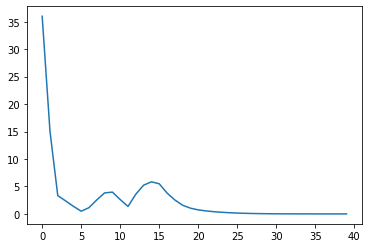

In [155]:
# compute and plot the TV spectrum
A = triangle_area(v, f)
S = np.sum(np.abs(A * np.linalg.norm(phi, axis=2)), axis=1)

plt.plot(S)
plt.show()

`vertex_from_normals` solves the screened poisson equation, on the domain M, associated to the minimization problem:
$$
\min_V  ||\nabla V - W ||_2^2 +eps||V-V_0||_2^2
$$
computing new vertices  coordinates according to the vector field W obtained from the normal vector field n, solving a screened poisson equation, according to M.Kazhdhan, H.Hoppe "Screened Poisson Surface Reconstruction"

In [156]:
p = mp.plot(v, f, return_plot=True)

@mp.interact(eigenvectors=(1, len(phi)))
def ff(eigenvectors):
    pin = np.arange(eigenvectors, len(phi))
    phi_recon = np.copy(phi)
    phi_recon[pin] = 0
    vr = vertex_from_normals(v, f, np.sum(phi_recon, 0))
    p.update_object(vertices=vr)
p

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.075344…

interactive(children=(IntSlider(value=20, description='eigenvectors', max=40, min=1), Output()), _dom_classes=…

In [157]:
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.075344…